In [1]:
import os

os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"

import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import uMAIA
from uMAIA.utils.tools import extract_image_coordinates
import pandas as pd
import tqdm

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_ranges_test(smz, PF, clip=100, img_shape=None):
    """
    Extract images from the smzObj according to extracted ranges defined in df and save into AnnData object (.h5ad) format
    
    Args
    ----
    smz: smzObj
    PF: Peakcalling object
    clip: int, optional
        percentile to clip images
        default, no clipping
    """
    
    tic_pixels = np.array(smz.S.sum(axis=1)).flatten()
    
    if img_shape is None:
        img_shape = smz.img_shape

    image_list = {}
    for i, r in tqdm.tqdm(enumerate(PF.ranges), total=len(PF.ranges)):

        mz_select_ = (smz.mz_vals > r[0]) & (smz.mz_vals < r[1])
        S_select = smz.S[:,mz_select_].toarray()
        mz = smz.mz_vals[mz_select_]

        img = np.sum(S_select, axis=1)
        # tic normalization
        img = img / tic_pixels

        # clip to nth percentile
        percentile = np.percentile(img, clip)
        img = np.clip(img, 0, percentile)

        if img.shape[0] < np.multiply(*img_shape):
            img = extract_image_coordinates(smz.reader.coordinates, img_shape, img)
        else:
            img = img[:np.multiply(*img_shape)].reshape(img_shape)
            
        image_list[f'{np.mean(r):.5f}'] = img
    return image_list

In [3]:
1000 * 10 * 1e-6 / 6

0.0016666666666666668

按照50-1300， 最大误差存在于1300处，此时误差为1300 * 10 * 10e-6, 在除个6,等于2.2e-3
但是大于1000的基本没啥靠谱信号，按1000算，mz_resolution约为1.667e-3

In [4]:
# set parameters
mz_resolution = 1.67e-3 #1e-4
threshold_count = 8.
# path_data = '/media/duan/sda2/MALDI/Data/20250829_2MP16MALDI/continuous_imzML_DHB/dhb_20u'
# name = 'dhb_20u'

smz = uMAIA.ut.SmzMLobj("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/a4-root mean square.ibd",
                           "/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/a4-root mean square.imzML",
                           mz_resolution=mz_resolution)#, selected_pixels=(0,4000))

smz.load(load_unique_mz=True)
smz.S

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
Loading Spectra at resolution 0.00167: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63506/63506 [00:01<00:00, 37556.18it/s]
Loading the m/z values at

<63506x1016 sparse matrix of type '<class 'numpy.float64'>'
	with 33972896 stored elements in Compressed Sparse Column format>

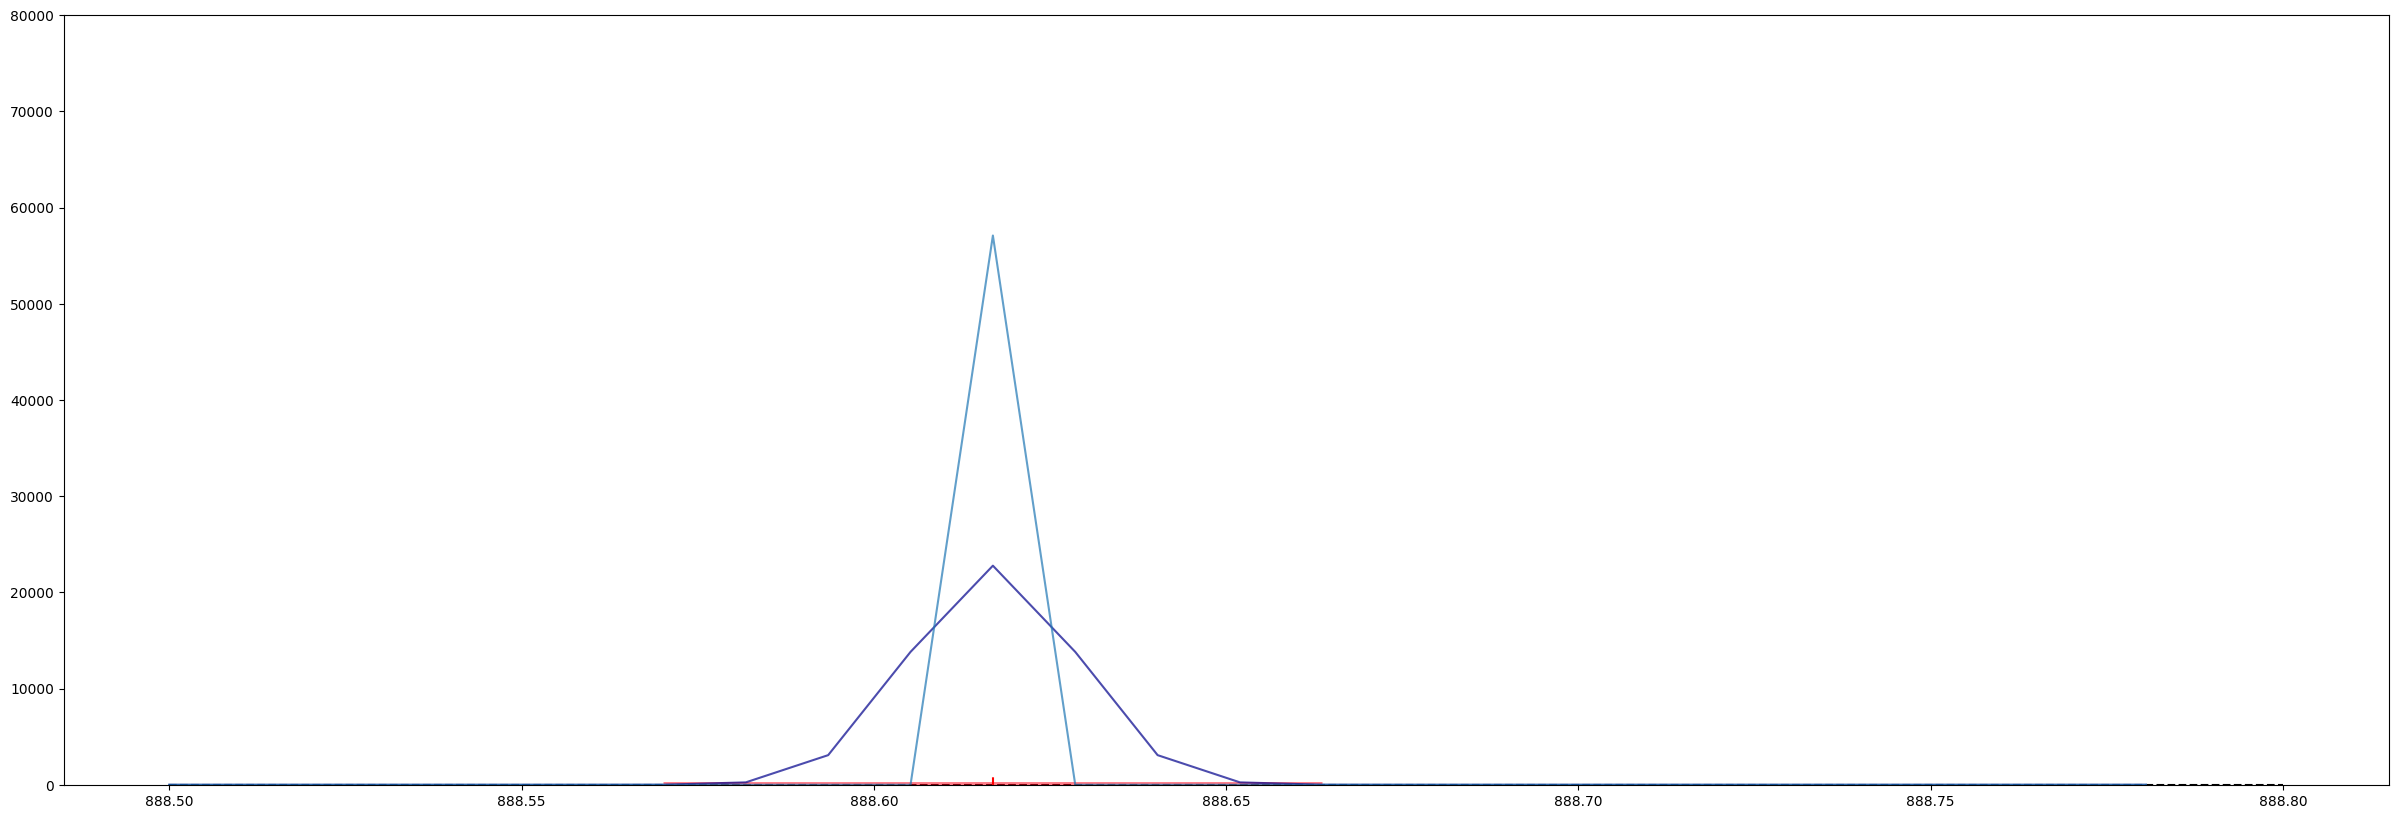

In [5]:
# smoothing on the frequency domain. for noisy mass errors, increase sigma, otherwise sigma can stay 
# a small value. use the plot_freqmz function to determine the best parameter for your dataset.
smoothing = 1.

# approximate interval refers to the size of the portion of the spectrum that is provided to the peak caller at a given instance
# if your machine throws an error, or the kernel stops, try decreasing this value
approximate_interval =.5


mzrange_test = np.array([888.5, 888.8]) # select a small window in the m/z spectrum that captures a reference compound
PF = uMAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=80000, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.86it/s]


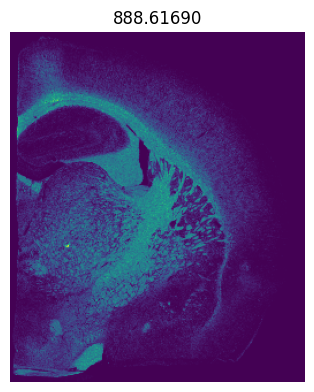

In [6]:
images = visualize_ranges_test(smz, PF)
fig = plt.figure(None, (20,10))
gs = plt.GridSpec(2,4)
for i, (mz, img) in enumerate(images.items()):
    plt.subplot(gs[i])
    plt.imshow(img)
    plt.title(mz)
    plt.axis('off')

In [7]:
smz

In [8]:
uMAIA.pf.run(directory_path="/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4", # input directory for saving peak-called objects
            smz=smz, 
            spectrum_range=(130,1300), # indicate the mz spectrum you wish to image
            threshold_count=threshold_count, 
            approximate_interval=approximate_interval,
            smoothing=smoothing,
            parallelize=True,
            saveimages=True  # whether images should be saved automatically
            )

Partioning m/z space and beginning peakcalling...


  0%|                                                                                                                                                                                                                                                                  | 0/469 [00:00<?, ?it/s]

invalid mz_range
invalid mz_range
invalid mz_range


  0%|▌                                                                                                                                                                                                                                                         | 1/469 [00:00<07:31,  1.04it/s]

invalid mz_range
invalid mz_range


  0%|█                                                                                                                                                                                                                                                         | 2/469 [00:03<14:45,  1.90s/it]

invalid mz_range
invalid mz_range


  1%|█▌                                                                                                                                                                                                                                                        | 3/469 [00:06<19:02,  2.45s/it]

invalid mz_range
invalid mz_range


  1%|██▏                                                                                                                                                                                                                                                       | 4/469 [00:08<17:15,  2.23s/it]

invalid mz_range
invalid mz_range


  1%|██▋                                                                                                                                                                                                                                                       | 5/469 [00:10<17:51,  2.31s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  1%|███▏                                                                                                                                                                                                                                                      | 6/469 [00:11<12:30,  1.62s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  1%|███▋                                                                                                                                                                                                                                                      | 7/469 [00:12<10:46,  1.40s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  2%|████▎                                                                                                                                                                                                                                                     | 8/469 [00:12<08:06,  1.06s/it]

invalid mz_range


  2%|████▊                                                                                                                                                                                                                                                     | 9/469 [00:18<19:15,  2.51s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  2%|█████▎                                                                                                                                                                                                                                                   | 10/469 [00:19<15:29,  2.02s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  2%|█████▊                                                                                                                                                                                                                                                   | 11/469 [00:19<12:12,  1.60s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  3%|██████▉                                                                                                                                                                                                                                                  | 13/469 [00:20<07:32,  1.01it/s]

invalid mz_range
invalid mz_range


  3%|███████▍                                                                                                                                                                                                                                                 | 14/469 [00:22<09:25,  1.24s/it]

invalid mz_range


  3%|████████▍                                                                                                                                                                                                                                                | 16/469 [00:27<12:35,  1.67s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  4%|█████████                                                                                                                                                                                                                                                | 17/469 [00:29<13:24,  1.78s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  4%|█████████▌                                                                                                                                                                                                                                               | 18/469 [00:30<11:00,  1.46s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  4%|██████████                                                                                                                                                                                                                                               | 19/469 [00:32<11:42,  1.56s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  4%|██████████▌                                                                                                                                                                                                                                              | 20/469 [00:34<12:41,  1.70s/it]

invalid mz_range


  4%|███████████▏                                                                                                                                                                                                                                             | 21/469 [00:40<22:53,  3.07s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  5%|███████████▋                                                                                                                                                                                                                                             | 22/469 [00:41<17:32,  2.35s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  5%|████████████▏                                                                                                                                                                                                                                            | 23/469 [00:41<14:02,  1.89s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  5%|████████████▋                                                                                                                                                                                                                                            | 24/469 [00:43<12:22,  1.67s/it]

invalid mz_range
invalid mz_range


  5%|█████████████▎                                                                                                                                                                                                                                           | 25/469 [00:46<16:57,  2.29s/it]

invalid mz_range
invalid mz_range


  6%|█████████████▊                                                                                                                                                                                                                                           | 26/469 [00:49<17:59,  2.44s/it]

invalid mz_range


  6%|██████████████▎                                                                                                                                                                                                                                          | 27/469 [00:59<35:01,  4.75s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  6%|██████████████▊                                                                                                                                                                                                                                          | 28/469 [01:00<25:13,  3.43s/it]

invalid mz_range


  6%|███████████████▍                                                                                                                                                                                                                                         | 29/469 [01:04<26:30,  3.61s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  6%|███████████████▉                                                                                                                                                                                                                                         | 30/469 [01:06<22:42,  3.10s/it]

invalid mz_range


  7%|████████████████▍                                                                                                                                                                                                                                        | 31/469 [01:11<27:08,  3.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  7%|████████████████▉                                                                                                                                                                                                                                        | 32/469 [01:12<20:49,  2.86s/it]

invalid mz_range


  7%|█████████████████▌                                                                                                                                                                                                                                       | 33/469 [01:16<24:15,  3.34s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  7%|██████████████████                                                                                                                                                                                                                                       | 34/469 [01:17<19:14,  2.65s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  7%|██████████████████▌                                                                                                                                                                                                                                      | 35/469 [01:19<16:56,  2.34s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  8%|███████████████████                                                                                                                                                                                                                                      | 36/469 [01:19<13:10,  1.83s/it]

invalid mz_range


  8%|███████████████████▋                                                                                                                                                                                                                                     | 37/469 [01:23<17:39,  2.45s/it]

invalid mz_range
invalid mz_range


  8%|████████████████████▏                                                                                                                                                                                                                                    | 38/469 [01:26<19:17,  2.69s/it]

invalid mz_range


  8%|████████████████████▋                                                                                                                                                                                                                                    | 39/469 [01:31<23:25,  3.27s/it]

invalid mz_range
invalid mz_range


  9%|█████████████████████▏                                                                                                                                                                                                                                   | 40/469 [01:33<21:12,  2.97s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  9%|█████████████████████▊                                                                                                                                                                                                                                   | 41/469 [01:35<18:51,  2.64s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  9%|██████████████████████▎                                                                                                                                                                                                                                  | 42/469 [01:36<14:56,  2.10s/it]

invalid mz_range
invalid mz_range


  9%|██████████████████████▊                                                                                                                                                                                                                                  | 43/469 [01:38<13:46,  1.94s/it]

invalid mz_range
invalid mz_range


  9%|███████████████████████▎                                                                                                                                                                                                                                 | 44/469 [01:40<15:30,  2.19s/it]

invalid mz_range


 10%|███████████████████████▉                                                                                                                                                                                                                                 | 45/469 [01:47<25:35,  3.62s/it]

invalid mz_range


 10%|████████████████████████▍                                                                                                                                                                                                                                | 46/469 [01:52<27:34,  3.91s/it]

invalid mz_range
invalid mz_range


 10%|█████████████████████████▍                                                                                                                                                                                                                               | 48/469 [01:54<16:43,  2.38s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 10%|██████████████████████████                                                                                                                                                                                                                               | 49/469 [01:56<16:25,  2.35s/it]

invalid mz_range


 11%|███████████████████████████                                                                                                                                                                                                                              | 51/469 [02:10<32:16,  4.63s/it]

invalid mz_range


 11%|███████████████████████████▌                                                                                                                                                                                                                             | 52/469 [02:13<30:29,  4.39s/it]

invalid mz_range
invalid mz_range


 11%|████████████████████████████▏                                                                                                                                                                                                                            | 53/469 [02:15<24:28,  3.53s/it]

invalid mz_range
invalid mz_range


 12%|████████████████████████████▋                                                                                                                                                                                                                            | 54/469 [02:17<21:30,  3.11s/it]

invalid mz_range
invalid mz_range


 12%|█████████████████████████████▏                                                                                                                                                                                                                           | 55/469 [02:21<22:25,  3.25s/it]

invalid mz_range


 12%|█████████████████████████████▋                                                                                                                                                                                                                           | 56/469 [02:23<21:10,  3.08s/it]

invalid mz_range
invalid mz_range


 12%|██████████████████████████████▎                                                                                                                                                                                                                          | 57/469 [02:27<21:41,  3.16s/it]

invalid mz_range
invalid mz_range


 12%|██████████████████████████████▊                                                                                                                                                                                                                          | 58/469 [02:30<22:53,  3.34s/it]

invalid mz_range
invalid mz_range


 13%|███████████████████████████████▎                                                                                                                                                                                                                         | 59/469 [02:34<23:50,  3.49s/it]

invalid mz_range
invalid mz_range


 13%|████████████████████████████████▍                                                                                                                                                                                                                        | 61/469 [02:43<28:11,  4.14s/it]

invalid mz_range
invalid mz_range


 13%|████████████████████████████████▉                                                                                                                                                                                                                        | 62/469 [02:46<25:43,  3.79s/it]

invalid mz_range
invalid mz_range


 13%|█████████████████████████████████▍                                                                                                                                                                                                                       | 63/469 [02:49<23:28,  3.47s/it]

invalid mz_range
invalid mz_range


 14%|█████████████████████████████████▉                                                                                                                                                                                                                       | 64/469 [02:51<21:55,  3.25s/it]

invalid mz_range


 14%|██████████████████████████████████▌                                                                                                                                                                                                                      | 65/469 [02:56<23:52,  3.55s/it]

invalid mz_range
invalid mz_range


 14%|███████████████████████████████████                                                                                                                                                                                                                      | 66/469 [02:59<22:58,  3.42s/it]

invalid mz_range
invalid mz_range


 14%|███████████████████████████████████▌                                                                                                                                                                                                                     | 67/469 [03:02<22:02,  3.29s/it]

invalid mz_range


 14%|████████████████████████████████████                                                                                                                                                                                                                     | 68/469 [03:08<27:18,  4.08s/it]

invalid mz_range
invalid mz_range


 15%|████████████████████████████████████▋                                                                                                                                                                                                                    | 69/469 [03:12<28:06,  4.22s/it]

invalid mz_range
invalid mz_range


 15%|█████████████████████████████████████▏                                                                                                                                                                                                                   | 70/469 [03:15<26:09,  3.93s/it]

invalid mz_range
invalid mz_range


 15%|█████████████████████████████████████▋                                                                                                                                                                                                                   | 71/469 [03:21<29:08,  4.39s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 15%|██████████████████████████████████████▏                                                                                                                                                                                                                  | 72/469 [03:22<23:02,  3.48s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 16%|██████████████████████████████████████▊                                                                                                                                                                                                                  | 73/469 [03:23<17:32,  2.66s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 16%|███████████████████████████████████████▊                                                                                                                                                                                                                 | 75/469 [03:35<30:57,  4.71s/it]

invalid mz_range
invalid mz_range


 16%|████████████████████████████████████████▎                                                                                                                                                                                                                | 76/469 [03:38<28:01,  4.28s/it]

invalid mz_range
invalid mz_range


 16%|████████████████████████████████████████▉                                                                                                                                                                                                                | 77/469 [03:40<22:55,  3.51s/it]

invalid mz_range
invalid mz_range


 17%|█████████████████████████████████████████▍                                                                                                                                                                                                               | 78/469 [03:42<19:05,  2.93s/it]

invalid mz_range


 17%|█████████████████████████████████████████▉                                                                                                                                                                                                               | 79/469 [03:51<31:33,  4.85s/it]

invalid mz_range
invalid mz_range


 17%|██████████████████████████████████████████▍                                                                                                                                                                                                              | 80/469 [03:55<29:30,  4.55s/it]

invalid mz_range
invalid mz_range


 17%|███████████████████████████████████████████                                                                                                                                                                                                              | 81/469 [03:59<28:21,  4.38s/it]

invalid mz_range
invalid mz_range


 17%|███████████████████████████████████████████▌                                                                                                                                                                                                             | 82/469 [04:02<24:46,  3.84s/it]

invalid mz_rangeinvalid mz_range

invalid mz_range
invalid mz_range


 18%|████████████████████████████████████████████                                                                                                                                                                                                             | 83/469 [04:02<17:50,  2.77s/it]

invalid mz_range
invalid mz_range


 18%|████████████████████████████████████████████▌                                                                                                                                                                                                            | 84/469 [04:06<20:44,  3.23s/it]

invalid mz_range


 18%|█████████████████████████████████████████████▏                                                                                                                                                                                                           | 85/469 [04:13<28:07,  4.39s/it]

invalid mz_range
invalid mz_range


 18%|█████████████████████████████████████████████▋                                                                                                                                                                                                           | 86/469 [04:18<28:12,  4.42s/it]

invalid mz_range
invalid mz_range


 19%|██████████████████████████████████████████████▏                                                                                                                                                                                                          | 87/469 [04:22<27:48,  4.37s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 19%|██████████████████████████████████████████████▋                                                                                                                                                                                                          | 88/469 [04:22<20:21,  3.21s/it]

invalid mz_range
invalid mz_range


 19%|███████████████████████████████████████████████▎                                                                                                                                                                                                         | 89/469 [04:26<21:22,  3.37s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 19%|███████████████████████████████████████████████▊                                                                                                                                                                                                         | 90/469 [04:28<19:12,  3.04s/it]

invalid mz_range
invalid mz_range


 19%|████████████████████████████████████████████████▎                                                                                                                                                                                                        | 91/469 [04:31<18:11,  2.89s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 20%|████████████████████████████████████████████████▊                                                                                                                                                                                                        | 92/469 [04:31<13:13,  2.10s/it]

invalid mz_range


 20%|█████████████████████████████████████████████████▍                                                                                                                                                                                                       | 93/469 [04:35<17:03,  2.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 20%|█████████████████████████████████████████████████▉                                                                                                                                                                                                       | 94/469 [04:37<15:42,  2.51s/it]

invalid mz_range
invalid mz_range


 20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                      | 95/469 [04:41<18:33,  2.98s/it]

invalid mz_range
invalid mz_range


 20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                      | 96/469 [04:44<18:26,  2.97s/it]

invalid mz_range
invalid mz_range


 21%|███████████████████████████████████████████████████▍                                                                                                                                                                                                     | 97/469 [04:46<15:56,  2.57s/it]

invalid mz_range
invalid mz_range


 21%|████████████████████████████████████████████████████                                                                                                                                                                                                     | 98/469 [04:47<12:25,  2.01s/it]

invalid mz_range
invalid mz_range


 21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 99/469 [04:50<14:01,  2.27s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 21%|████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 100/469 [04:52<13:35,  2.21s/it]

invalid mz_range
invalid mz_range


 22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 101/469 [04:56<16:39,  2.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 22%|█████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 102/469 [04:58<15:54,  2.60s/it]

invalid mz_range
invalid mz_range


 22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 103/469 [05:02<18:15,  2.99s/it]

invalid mz_range
invalid mz_range


 22%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 104/469 [05:03<15:23,  2.53s/it]

invalid mz_range


 22%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                | 105/469 [05:11<24:14,  4.00s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 23%|████████████████████████████████████████████████████████                                                                                                                                                                                                | 106/469 [05:12<18:39,  3.08s/it]

invalid mz_range
invalid mz_range


 23%|████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 107/469 [05:15<18:22,  3.05s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 23%|█████████████████████████████████████████████████████████                                                                                                                                                                                               | 108/469 [05:16<15:34,  2.59s/it]

invalid mz_range
invalid mz_range


 23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 109/469 [05:19<16:12,  2.70s/it]

invalid mz_range
invalid mz_range


 23%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 110/469 [05:23<17:38,  2.95s/it]

invalid mz_range
invalid mz_range


 24%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 111/469 [05:26<19:01,  3.19s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 24%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 112/469 [05:29<17:19,  2.91s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 24%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 113/469 [05:31<15:37,  2.63s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 24%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 114/469 [05:32<14:08,  2.39s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                           | 115/469 [05:34<13:18,  2.26s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 25%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 116/469 [05:37<12:57,  2.20s/it]

invalid mz_range
invalid mz_range


 25%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                          | 117/469 [05:38<12:06,  2.06s/it]

invalid mz_range
invalid mz_range


 25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 118/469 [05:39<10:11,  1.74s/it]

invalid mz_range
invalid mz_range


 25%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 119/469 [05:42<11:26,  1.96s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 26%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 120/469 [05:42<08:42,  1.50s/it]

invalid mz_range
invalid mz_range


 26%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 121/469 [05:45<10:44,  1.85s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 26%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 122/469 [05:46<09:45,  1.69s/it]

invalid mz_range
invalid mz_range


 26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 123/469 [05:50<13:43,  2.38s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 26%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 124/469 [05:50<10:10,  1.77s/it]

invalid mz_range
invalid mz_range


 27%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 125/469 [05:54<13:25,  2.34s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 27%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 126/469 [05:56<12:24,  2.17s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 27%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 127/469 [05:57<10:29,  1.84s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 28%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 129/469 [06:02<12:32,  2.21s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 28%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 130/469 [06:03<11:07,  1.97s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 28%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 131/469 [06:05<10:32,  1.87s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 28%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 132/469 [06:06<09:12,  1.64s/it]

invalid mz_range
invalid mz_range


 28%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 133/469 [06:09<10:38,  1.90s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 29%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 134/469 [06:09<08:04,  1.45s/it]

invalid mz_range
invalid mz_range


 29%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 135/469 [06:11<09:34,  1.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 29%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 136/469 [06:12<08:33,  1.54s/it]

invalid mz_range
invalid mz_range


 29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 137/469 [06:14<08:19,  1.50s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 29%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 138/469 [06:14<06:28,  1.17s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 30%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 139/469 [06:15<05:41,  1.03s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 30%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 140/469 [06:16<06:02,  1.10s/it]

invalid mz_range
invalid mz_range


 30%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 141/469 [06:19<08:50,  1.62s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 30%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 142/469 [06:20<07:43,  1.42s/it]

invalid mz_range
invalid mz_range


 30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 143/469 [06:21<06:50,  1.26s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 144/469 [06:21<05:28,  1.01s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 145/469 [06:22<04:57,  1.09it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 146/469 [06:23<05:09,  1.04it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 147/469 [06:24<04:28,  1.20it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 32%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 148/469 [06:24<03:54,  1.37it/s]

invalid mz_range
invalid mz_range


 32%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 149/469 [06:25<04:42,  1.13it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 32%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 150/469 [06:26<04:29,  1.18it/s]

invalid mz_range


 32%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 151/469 [06:32<12:04,  2.28s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 152/469 [06:32<09:31,  1.80s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 33%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 153/469 [06:33<07:26,  1.41s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 33%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 155/469 [06:34<05:47,  1.11s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 33%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 156/469 [06:35<05:27,  1.04s/it]

invalid mz_range
invalid mz_range


 33%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 157/469 [06:37<06:43,  1.29s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 34%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 158/469 [06:38<06:03,  1.17s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 34%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 159/469 [06:39<05:21,  1.04s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 34%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 160/469 [06:40<04:52,  1.05it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 35%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 162/469 [06:40<03:25,  1.49it/s]

invalid mz_range
invalid mz_range


 35%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 163/469 [06:43<05:34,  1.09s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 35%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 164/469 [06:43<04:54,  1.03it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 166/469 [06:44<03:35,  1.41it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 36%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 167/469 [06:44<02:46,  1.82it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 36%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 168/469 [06:45<03:06,  1.61it/s]

invalid mz_range
invalid mz_range


 36%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 169/469 [06:46<03:27,  1.45it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 36%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 170/469 [06:46<02:51,  1.74it/s]

invalid mz_range
invalid mz_range


 36%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 171/469 [06:47<03:32,  1.40it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 37%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 172/469 [06:48<02:50,  1.74it/s]

invalid mz_range
invalid mz_range


 37%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 173/469 [06:50<04:48,  1.03it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 38%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 176/469 [06:52<04:02,  1.21it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 38%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 177/469 [06:52<03:09,  1.54it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 38%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 180/469 [06:54<02:46,  1.74it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 39%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 181/469 [06:54<02:26,  1.96it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 39%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 182/469 [06:54<02:14,  2.13it/s]

invalid mz_rangeinvalid mz_range

invalid mz_range


 39%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 183/469 [06:55<02:20,  2.04it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 39%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 185/469 [06:56<01:55,  2.47it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 188/469 [06:56<01:30,  3.10it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 190/469 [06:57<01:10,  3.95it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 191/469 [06:57<01:39,  2.78it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 192/469 [06:58<01:36,  2.87it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 194/469 [06:58<01:17,  3.55it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 196/469 [06:58<00:54,  5.05it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 198/469 [06:59<00:49,  5.51it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 203/469 [06:59<00:30,  8.67it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 206/469 [06:59<00:32,  8.10it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 210/469 [07:00<00:26,  9.65it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 213/469 [07:00<00:21, 11.75it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 217/469 [07:01<00:27,  9.20it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 220/469 [07:01<00:33,  7.44it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 223/469 [07:01<00:23, 10.28it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 227/469 [07:03<00:48,  5.00it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 229/469 [07:04<01:18,  3.04it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 235/469 [07:05<01:06,  3.50it/s]

invalid mz_range
invalid mz_range


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 236/469 [07:08<02:01,  1.91it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 237/469 [07:09<02:20,  1.65it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 238/469 [07:10<02:48,  1.37it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 239/469 [07:12<03:33,  1.08it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 242/469 [07:14<02:37,  1.44it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 244/469 [07:14<01:51,  2.02it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 245/469 [07:15<01:44,  2.15it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 246/469 [07:16<02:51,  1.30it/s]

invalid mz_range
invalid mz_range


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 247/469 [07:20<05:22,  1.45s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 248/469 [07:20<04:20,  1.18s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 250/469 [07:21<02:33,  1.43it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 251/469 [07:21<01:58,  1.84it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 254/469 [07:23<02:27,  1.46it/s]

invalid mz_range
invalid mz_range


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 255/469 [07:25<03:29,  1.02it/s]

invalid mz_range
invalid mz_range


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 257/469 [07:27<02:53,  1.23it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 258/469 [07:27<02:15,  1.55it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 259/469 [07:29<03:25,  1.02it/s]

invalid mz_range
invalid mz_range


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 260/469 [07:31<04:29,  1.29s/it]

invalid mz_range
invalid mz_range


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 261/469 [07:32<03:52,  1.12s/it]

invalid mz_rangeinvalid mz_range
invalid mz_range

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 264/469 [07:32<01:59,  1.72it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 265/469 [07:36<04:28,  1.32s/it]

invalid mz_range
invalid mz_range


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 266/469 [07:37<04:17,  1.27s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 267/469 [07:37<03:34,  1.06s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 270/469 [07:38<01:57,  1.69it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 271/469 [07:38<01:43,  1.92it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 272/469 [07:39<01:57,  1.68it/s]

invalid mz_rangeinvalid mz_range

invalid mz_range


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 276/469 [07:40<00:58,  3.28it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 277/469 [07:40<01:08,  2.80it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 279/469 [07:41<00:58,  3.23it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 282/469 [07:43<01:33,  1.99it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 286/469 [07:43<00:52,  3.51it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 289/469 [07:45<01:03,  2.81it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 291/469 [07:45<00:51,  3.43it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 292/469 [07:45<00:54,  3.26it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 293/469 [07:46<01:05,  2.71it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 298/469 [07:47<00:33,  5.15it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 299/469 [07:47<00:33,  5.09it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 300/469 [07:49<01:23,  2.02it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 301/469 [07:49<01:17,  2.18it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 302/469 [07:50<01:48,  1.53it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 303/469 [07:52<02:43,  1.01it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 306/469 [07:53<01:20,  2.03it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 310/469 [07:53<00:38,  4.09it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 315/469 [07:55<00:42,  3.62it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 324/469 [07:55<00:15,  9.38it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 350/469 [07:55<00:04, 28.30it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 394/469 [07:55<00:00, 82.66it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 463/469 [07:56<00:00, 171.19it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [07:56<00:00,  1.02s/it]


Creating dataframe...


  0%|                                                                                                                                                                                                                                                                 | 0/2727 [00:00<?, ?it/s]/media/duan/sda2/MALDI/software/uMAIA/uMAIA/peak_finding/_run.py:213: RuntimeWarning: invalid value encountered in scalar divide
  percent_1_hit = np.sum(S_selected == 1.) / np.sum(S_selected >= 1.) * 100
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2727/2727 [00:03<00:00, 772.03it/s]


DataFrame created successfully
Removing temporary storage
Saving images...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.60it/s]


Complete


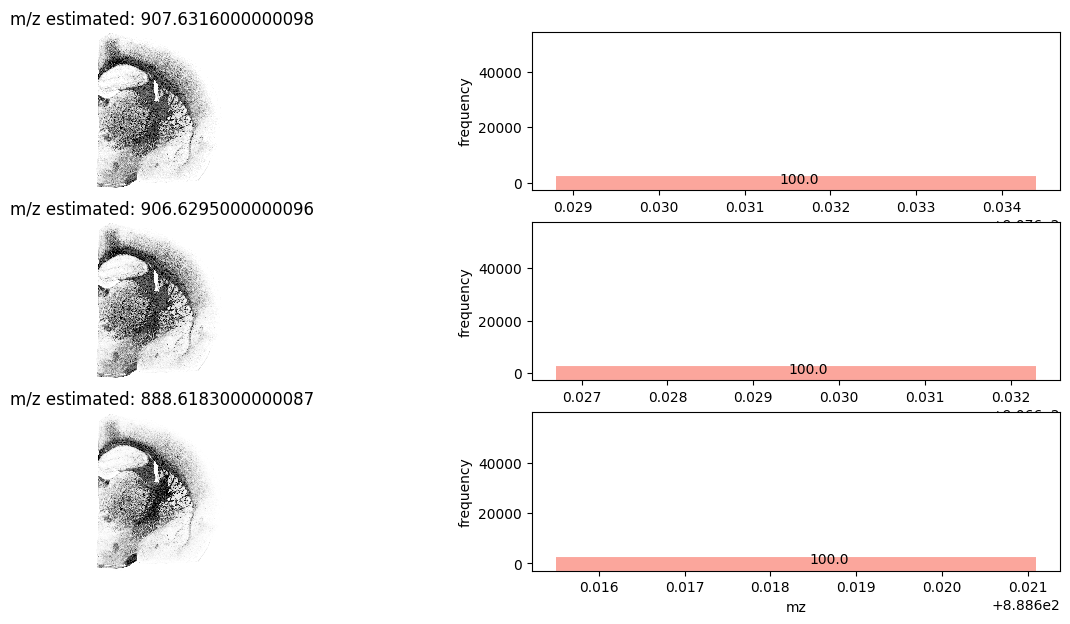

In [9]:
df_ranges = pd.read_csv("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/ranges.csv", index_col=0)

adduct_H = -1.0078
adduct_H2O = - 18.0150 - 1.0078
s_mz = 907.641851


fig, mz_images = uMAIA.vis.image_mz(smz, df=df_ranges, normalize = None,
                             mz_list=[s_mz, s_mz + adduct_H, s_mz + adduct_H2O], 
                             cmap='Greys',figsize=(15,7),
                             img_shape=smz.img_shape, limit=0.01,clip=99,
                            )

In [10]:
import scanpy as sc
import numpy as np

In [11]:
adata = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/images.h5ad")
adata

AnnData object with n_obs × n_vars = 77824 × 1000
    var: '0'
    uns: 'img_shape'

In [12]:
X, Y = adata.uns['img_shape']

In [13]:
spatials = []

for x in range(X):
    for y in range(Y):
        spatials.append([y,x])

In [14]:
adata.obsm['spatial'] = np.array(spatials)

In [15]:
adata.var.columns = ['m/z']
adata.var_names = adata.var['m/z'].round(5).map('{:.5f}'.format)

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


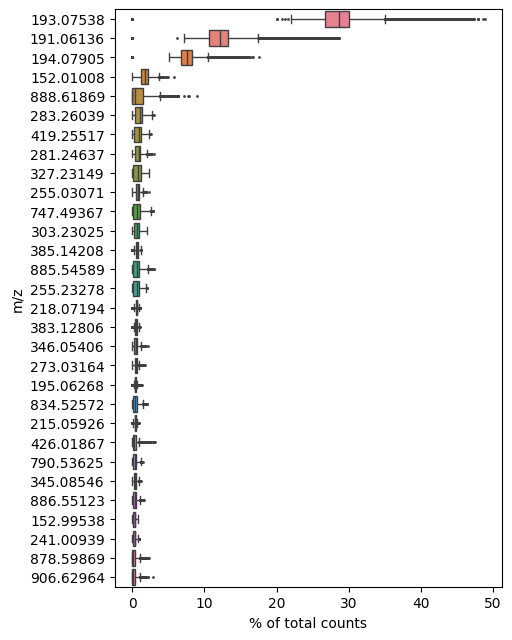

In [16]:
sc.pl.highest_expr_genes(adata)

In [17]:
X/35

8.685714285714285

In [18]:
Y/35

7.314285714285714

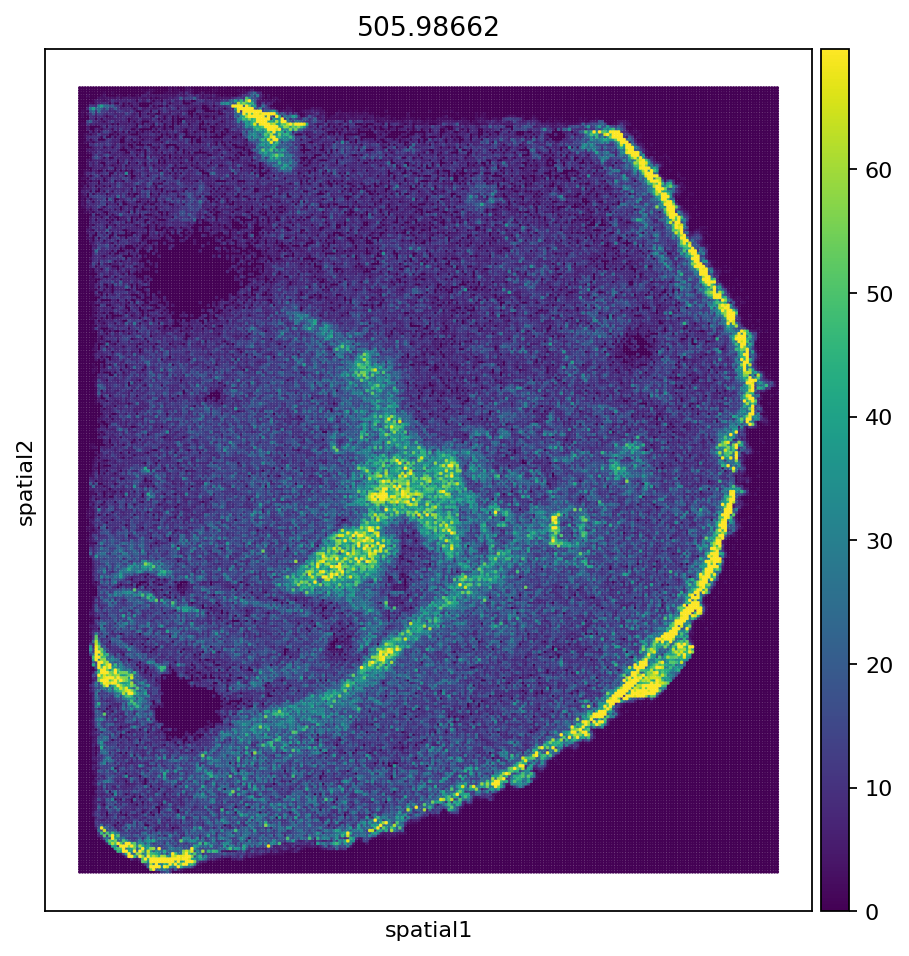

In [22]:
sc.set_figure_params(figsize = (6.8,7), scanpy = False)
sc.pl.embedding(adata, basis = 'spatial', color = '505.98662', vmax = 'p99', size = 10)

In [21]:
adata.write_h5ad("MALDI/9AA_A4_uMAIA_raw.h5ad")

In [10]:
import pandas as pd

In [11]:
ref_meta = pd.read_excel("/media/duan/sda2/MALDI/Data/20250923_LCMS2_mzML/all_sample_data.xlsx")
ref_meta

Index         Mode  \
0     MW0168692  T3_positive   
1     MW0194064  T3_positive   
2     MW0169283  T3_positive   
3     MW0054524  T3_positive   
4     MW0159863  T3_positive   
...         ...          ...   
2424  MW0166304  T3_negative   
2425  MW0164541  T3_negative   
2426  MW0144100  T3_negative   
2427  MW0104948  T3_negative   
2428  MW0003452  T3_negative   

                                              Compounds  \
0                                             Adenosine   
1                                    Acetyl-L-carnitine   
2                               2-Amino-1-phenylethanol   
3                                         LPC(16:0_0:0)   
4                                          Hypoxanthine   
...                                                 ...   
2424                                        Resolvin D1   
2425                                       12,13-DiHOME   
2426                                             9-HEPE   
2427    3-[4-(sulfooxy)phenyl]oxirane-2-carboxylic acid   
2428  3-(3,4-dimethoxyphenyl)-N-[2-(3,4-dimethoxyphe...   

                                               物质  \
0                                              腺苷   
1                                          乙酰左旋肉碱   
2                                     2-氨基-1-苯基乙醇   
3                                   LPC(16:0_0:0)   
4                                            次黄嘌呤   
...                                           ...   
2424                                            -   
2425                                            -   
2426                                            -   
2427                       3-[4-(磺氧基）苯基]环氧乙烷-2-羧酸   
2428  3-(3,4-二甲氧基苯基)-N-[2-(3,4-二甲氧基苯基）乙基]-3-羟基丙二酸   

                                  Super.Class Superclass.Chinese  \
0     Nucleosides, nucleotides, and analogues         核苷、核苷酸和类似物   
1             Lipids and lipid-like molecules            脂质和类脂分子   
2                  Organic nitrogen compounds             有机氮化合物   
3             Lipids and lipid-like molecules            脂质和类脂分子   
4                Organoheterocyclic compounds            有机杂环化合物   
...                                       ...                ...   
2424          Lipids and lipid-like molecules            脂质和类脂分子   
2425          Lipids and lipid-like molecules            脂质和类脂分子   
2426          Lipids and lipid-like molecules            脂质和类脂分子   
2427            Organic acids and derivatives           有机酸及其衍生物   
2428                               Benzenoids             苯环型化合物   

                                       Class Class.Chinese  \
0                         Purine nucleosides         嘌呤核苷类   
1                                Fatty Acyls         脂肪酰基类   
2                   Organonitrogen compounds        有机氮化合物   
3                       Glycerophospholipids         甘油磷脂类   
4                         Imidazopyrimidines     咪唑并嘧啶类化合物   
...                                      ...           ...   
2424                             Fatty Acyls         脂肪酰基类   
2425                             Fatty Acyls         脂肪酰基类   
2426                             Fatty Acyls         脂肪酰基类   
2427  Organic sulfuric acids and derivatives     有机硫酸及其衍生物   
2428     Benzene and substituted derivatives      苯及取代苯衍生物   

                           Sub.Class Subclass.Chinese  ...      Saline1A  \
0                                  -                -  ...  2.338430e+08   
1                  Fatty acid esters            脂肪酸酯类  ...  1.928334e+08   
2                             Amines               胺类  ...  4.656008e+06   
3             Glycerophosphocholines         甘油磷脂酰胆碱类  ...  4.731822e+07   
4     Purines and purine derivatives          嘌呤及其衍生物  ...  7.931713e+07   
...                              ...              ...  ...           ...   
2424      Fatty acids and conjugates         脂肪酸及其缀合物  ...  1.269974e+06   
2425      Fatty acids and conjugates         脂肪酸及其缀合物  ...  3.435068e+06   
2426                     Eicosano

In [125]:
ref_meta.columns

Index(['Index', 'Mode', 'Compounds', '物质', 'Super.Class', 'Superclass.Chinese',
       'Class', 'Class.Chinese', 'Sub.Class', 'Subclass.Chinese', 'Formula',
       'Q1 (Da)', 'Molecular weight (Da)', 'RT (min)', 'Adduct', 'Mass error',
       'Level', 'score', 'LC mode', 'CAS', 'PubChem CID', 'HMDB', 'Metlin',
       'cpd_ID', 'LPS1A', 'LPS2A', 'LPS3A', 'LPS4A', 'LPS5A', 'LPS6A',
       'Saline1A', 'Saline2A', 'Saline3A', 'Saline4A', 'Saline5A', 'Saline6A',
       'QC01', 'QC02', 'QC03', 'kegg_map'],
      dtype='object')

In [126]:
adduct_dict = {
    'H': -1.0078,
    'Cl': 35.453,
    'H2O': - 18.0150
}

In [127]:
ref_meta['Level'].unique()

array(['1a', '1b', '2', '3', '4'], dtype=object)

In [12]:
ref_subset = ref_meta[(ref_meta['Mode'] == 'T3_negative')&(ref_meta['Level'].isin(['1a', '1b', '2', '3']))].copy()

In [13]:
ref_subset

Index         Mode  \
1522  MW0103577  T3_negative   
1523  MW0161724  T3_negative   
1524  MW0169372  T3_negative   
1525  MW0055180  T3_negative   
1526  MW0017129  T3_negative   
...         ...          ...   
2424  MW0166304  T3_negative   
2425  MW0164541  T3_negative   
2426  MW0144100  T3_negative   
2427  MW0104948  T3_negative   
2428  MW0003452  T3_negative   

                                              Compounds  \
1522                                          Guanosine   
1523                                        Citric acid   
1524                                  Pyroglutamic acid   
1525                                      Myristic acid   
1526                                          FFA(19:1)   
...                                                 ...   
2424                                        Resolvin D1   
2425                                       12,13-DiHOME   
2426                                             9-HEPE   
2427    3-[4-(sulfooxy)phenyl]oxirane-2-carboxylic acid   
2428  3-(3,4-dimethoxyphenyl)-N-[2-(3,4-dimethoxyphe...   

                                               物质  \
1522                                           鸟苷   
1523                                          柠檬酸   
1524                                         焦谷氨酸   
1525                                         肉豆蔻酸   
1526                                        十九碳烯酸   
...                                           ...   
2424                                            -   
2425                                            -   
2426                                            -   
2427                       3-[4-(磺氧基）苯基]环氧乙烷-2-羧酸   
2428  3-(3,4-二甲氧基苯基)-N-[2-(3,4-二甲氧基苯基）乙基]-3-羟基丙二酸   

                                  Super.Class Superclass.Chinese  \
1522  Nucleosides, nucleotides, and analogues         核苷、核苷酸和类似物   
1523            Organic acids and derivatives           有机酸及其衍生物   
1524            Organic acids and derivatives           有机酸及其衍生物   
1525          Lipids and lipid-like molecules            脂质和类脂分子   
1526          Lipids and lipid-like molecules            脂质和类脂分子   
...                                       ...                ...   
2424          Lipids and lipid-like molecules            脂质和类脂分子   
2425          Lipids and lipid-like molecules            脂质和类脂分子   
2426          Lipids and lipid-like molecules            脂质和类脂分子   
2427            Organic acids and derivatives           有机酸及其衍生物   
2428                               Benzenoids             苯环型化合物   

                                       Class Class.Chinese  \
1522                      Purine nucleosides         嘌呤核苷类   
1523        Carboxylic acids and derivatives       羧酸及其衍生物   
1524        Carboxylic acids and derivatives       羧酸及其衍生物   
1525                             Fatty Acyls         脂肪酰基类   
1526                             Fatty Acyls         脂肪酰基类   
...                                      ...           ...   
2424                             Fatty Acyls         脂肪酰基类   
2425                             Fatty Acyls         脂肪酰基类   
2426                             Fatty Acyls         脂肪酰基类   
2427  Organic sulfuric acids and derivatives     有机硫酸及其衍生物   
2428     Benzene and substituted derivatives      苯及取代苯衍生物   

                                 Sub.Class Subclass.Chinese  ...  \
1522                                     -                -  ...   
1523   Tricarboxylic acids and derivatives         三羧酸及其衍生物  ...   
1524  Amino acids, peptides, and analogues       氨基酸、肽及其类似物  ...   
1525            Fatty acids and conjugates         脂肪酸及其缀合物  ...   
1526            Fatty acids and conjugates         脂肪酸及其缀合物  ...   
...                                    ...              ...  ...   
2424            Fatty acids and conjugates         脂肪酸及其缀合物  ...   
2425            Fatty acids and conjugates         脂肪酸及其缀合物  ...   
2426                           Eicosanoids             花生酸类  ...   
2427                          Arylsul

In [130]:
import scanpy as sc
adata = sc.read_h5ad("9AA_8_20um_uMAIA_raw.h5ad")

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [131]:
adata.var_names = adata.var['m/z'].round(5).map('{:.5f}'.format)

In [132]:
adata

AnnData object with n_obs × n_vars = 82404 × 1069
    var: 'm/z'
    uns: 'img_shape'
    obsm: 'spatial'

In [133]:
adata.var

m/z
m/z                 
265.07409  265.07409
265.25111  265.25111
266.06941  266.06941
266.09446  266.09446
267.08978  267.08978
...              ...
802.51015  802.51015
802.53186  802.53186
803.45704  803.45704
803.53553  803.53553
804.52417  804.52417

[1069 rows x 1 columns]

In [15]:
target_mz = 235.08590
thred = target_mz * 1e-5

for adduct, dmz in adduct_dict.items():
    
    tmp = target_mz - dmz
    upper = tmp + thred
    lower = tmp - thred
    tmp_df = ref_subset[(ref_subset['Molecular weight (Da)'] >= lower)&(ref_subset['Molecular weight (Da)'] <= upper)].copy()
    if not len(tmp_df) == 0:
        print(f"M{adduct}: {tmp_df[['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level']].values[0]}")

In [135]:
from tqdm import tqdm

In [136]:
ref_subset['Adduct'].unique()

array(['[M-H]-', '[M-H2O-H]-', '[M+CH3COO]-', '[M+NH4-2H]-', '[M+Na-2H]-',
       '[M+HCOO]-', '[M+Cl]-', '[M-H+CH3CN]-', '[M-]-', '[2M-H]-',
       '[M+K-2H]-', '[M+F]-', '[M+Cl+NH3]-'], dtype=object)

In [16]:
235.08590 + 1.00078

236.08668

In [4]:
adduct_dict = {
    '-H': -1.0078,
    '+Cl': 35.453,
    '-H2O': - 18.0150
}

In [138]:
# 自动注释unique的，手动注释对上多个的，考虑代谢物的Level，表达量（QC01），以及现实情况

adata.var['Compounds1'] = "-"
adata.var['HMDB1'] = "-"
adata.var['Molecular weight (Da)1'] = "-"
adata.var['Level'] = "-"
adata.var['Adduct1'] = "-"


for m in adata.var_names:
    outs_dict = {}
    
    target_mz = float(m)
    thred = target_mz * 1e-5

    tmp_count = 0
    
    for adduct, dmz in adduct_dict.items():
    
        tmp = target_mz - dmz
        upper = tmp + thred
        lower = tmp - thred
        tmp_df = ref_subset[(ref_subset['Molecular weight (Da)'] >= lower)&(ref_subset['Molecular weight (Da)'] <= upper)].copy()
        if not len(tmp_df) == 0:
           outs_dict[f"M{adduct}"] = tmp_df[['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level', 'QC01']].values[0]
            # print(f"M+{adduct}: {tmp_df[['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level', 'QC01']].values[0]}")
    if outs_dict:
        df = pd.DataFrame(outs_dict).T
        df.columns = ['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level', 'QC01']
        if len(df) == 1:
            adduct_idx = df.index[0]
            adata.var.loc[m,"Compounds1"] = df.loc[adduct_idx, "Compounds"]
            adata.var.loc[m,"HMDB1"] = df.loc[adduct_idx, "HMDB"]
            adata.var.loc[m,"Molecular weight (Da)1"] = df.loc[adduct_idx, "Molecular weight (Da)"]
            adata.var.loc[m,"Level"] = df.loc[adduct_idx, "Level"]
            adata.var.loc[m,"Adduct1"] = adduct_idx
        else:
            print(m)
            print(df)
        # df = df.sort_values(['Level', 'QC01'], ascending=[True, False])
        # print(target_mz)
        # print(df)
        # print('--------------------------------------------------------------------------------------------------------------------------')
        # print(f"M+{adduct}: {tmp_df[['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level']].values[0]}")

    # if tmp_count > 0:
    #     Possible_annotated += 1
    #     Possible_annotated_count.append(tmp_count)

    # if tmp_count == 3:
    #     print(target_mz)

452.27441
           Compounds                             Sub.Class         HMDB  \
M-H    LPE(0:0_16:0)           Glycerophosphoethanolamines  HMDB0011473   
M-H2O   Ceanothine C  Amino acids, peptides, and analogues  HMDB0029340   

      Molecular weight (Da) Level          QC01  
M-H                453.2855     2  105354892.61  
M-H2O              470.2893     3    4964646.78  
279.23068
                    Compounds                   Sub.Class         HMDB  \
M-H      17-Octadecynoic acid  Fatty acids and conjugates  HMDB0244776   
M-H2O  9,10-Epoxystearic acid  Fatty acids and conjugates            -   

      Molecular weight (Da) Level         QC01  
M-H                280.2402     2   1611869.79  
M-H2O               297.243     2  14883299.54  
245.04077
                    Compounds         Sub.Class         HMDB  \
M-H    Glycerophosphoglycerol  Phosphate esters            -   
M-H2O             Ticlopidine                 -  HMDB0014353   

      Molecular weight (Da) Lev

In [143]:
m = '452.27441'
adata.var.loc[m,"Compounds1"] = 'LPE(0:0_16:0)'
adata.var.loc[m,"HMDB1"] = 'HMDB0011473'
adata.var.loc[m,"Molecular weight (Da)1"] = '453.2855'
adata.var.loc[m,"Level"] = '2'
adata.var.loc[m,"Adduct1"] = 'M-H'

m = '279.23068'
adata.var.loc[m,"Compounds1"] = '9,10-Epoxystearic acid'
adata.var.loc[m,"HMDB1"] = '-'
adata.var.loc[m,"Molecular weight (Da)1"] = '297.243'
adata.var.loc[m,"Level"] = '2'
adata.var.loc[m,"Adduct1"] = 'M-H2O'

m = '245.04077'
adata.var.loc[m,"Compounds1"] = 'Ticlopidine'
adata.var.loc[m,"HMDB1"] = 'HMDB0014353'
adata.var.loc[m,"Molecular weight (Da)1"] = '263.0535'
adata.var.loc[m,"Level"] = '3'
adata.var.loc[m,"Adduct1"] = 'M-H2O'

In [144]:
# 这篇文章的数据是负离子模式，DHB先不用
ref1 = pd.read_excel("41467_2025_59487_MOESM3_ESM.xlsx", sheet_name='metabolomics')
ref2 = pd.read_excel("41467_2025_59487_MOESM3_ESM.xlsx", sheet_name='lipidomics')

In [145]:
ref1

m/z                                     Name         HMDB   PubChem  \
0    87.0083                             Pyruvic acid  HMDB0000243      1060   
1    89.0239                            L-Lactic acid  HMDB0000190     61503   
2    96.9689                          Phosphoric acid  HMDB0002142  57424078   
3   117.0183                            Succinic acid  HMDB0000254      1110   
4   124.0067                                  Taurine  HMDB0000251      1123   
5   131.0820                                Ornithine  HMDB0000214      6262   
6   132.0295                          L-Aspartic acid  HMDB0000191      5960   
7   133.0131                             L-Malic acid  HMDB0000156    222656   
8   134.0463                                  Adenine  HMDB0000034       190   
9   135.0286                             Hypoxanthine  HMDB0000157       790   
10  140.0115                    O-Phosphoethanolamine  HMDB0000224      1015   
11  145.0614                              L-Glutamine  HMDB0000641      5961   
12  146.0457                          L-Glutamic acid  HMDB0000148     33032   
13  152.0710                                 Dopamine  HMDB0000073       681   
14  165.0564                        3-Methoxytyramine  HMDB0000022      1669   
15  167.0348          3,4-Dihydroxybenzeneacetic acid  HMDB0001336       547   
16  171.0062                   Glycerophosphoric acid  HMDB0252849       754   
17  173.0091                        cis-Aconitic acid  HMDB0000072    643757   
18  173.1040                               L-Arginine  HMDB0000517      6322   
19  174.0404                 N-Acetyl-L-aspartic acid  HMDB0000812     65065   
20  174.0878                               Citrulline  HMDB0000904      9750   
21  175.0229                            Ascorbic acid  HMDB0000044  54670067   
22  181.0503                        Homovanillic acid  HMDB0000118      1738   
23  184.9854                   3-Phosphoglyceric acid  HMDB0060180    439183   
24  191.0194                              Citric acid  HMDB0000094       311   
25  206.9824                  sn-Glycerol 3-phosphate  HMDB0000126    439162   
26  214.0483           Glycerylphosphorylethanolamine  HMDB0000114  22833510   
27  215.0320                                D-Glucose  HMDB0000122      5793   
28  259.0234                      Glucose 6-phosphate  HMDB0001401      5958   
29  267.0729                                  Inosine  HMDB0000195      6021   
30  279.2325                            Linoleic acid  HMDB0000673   5280450   
31  281.2478                               Oleic acid  HMDB0000207    445639   
32  283.2632                             Stearic acid  HMDB0000827      5281   
33  303.2322                         Arachidonic acid  HMDB0001043    444899   
34  306.0755                              Glutathione  HMDB0062697       745   
35  323.0266                 Uridine 5'-monophosphate  HMDB0000288      6030   
36  327.2320                     Docosahexaenoic acid  HMDB0002183    445580   
37  328.0437                               Cyclic AMP  HMDB0000058      6076   
38  346.0548                  Adenosine monophosphate  HMDB0000045      6083   
39  362.0497                  Guanosine monophosphate  HMDB0001397      6804   
40  375.2896                         Lithocholic acid  HMDB0000761  11740284   
41  385.3467                              Cholesterol  HMDB0000067      5997   
42  391.2848                    Chenodeoxycholic acid  HMDB0000626    222528   
43  391.2848                         Deoxycholic acid  HMDB0000518     10133   
44  391.2850                      Hyodeoxycholic acid  HMDB0000946     31401   
45  391.2852                     Ursodeoxycholic acid  HMDB0000733   9963687   
46  407.2784                              Cholic acid  HMDB0000619    221493   
47  426.0201                                      ADP  HMDB0001341      6022   
48  442.0150                    Guanosine diphosphate  HMDB0001201      8977   
49  445.0

In [146]:
# 自动注释unique的，手动注释对上多个的，考虑代谢物的Level，表达量（QC01），以及现实情况

adata.var['Compounds2'] = "-"
adata.var['HMDB2'] = "-"
adata.var['Molecular weight (Da)2'] = "-"
adata.var['Adduct2'] = "-"


for m in adata.var_names:
    outs_dict = {}
    
    target_mz = float(m)
    thred = target_mz * 1e-5

    tmp_count = 0
    
    for adduct, dmz in adduct_dict.items():
    
        tmp = target_mz - dmz
        upper = tmp + thred
        lower = tmp - thred
        tmp_df = ref1[(ref1['m/z'] >= lower)&(ref1['m/z'] <= upper)].copy()
        if not len(tmp_df) == 0:
           outs_dict[f"M{adduct}"] = tmp_df[['m/z', 'Name', 'HMDB', 'PubChem', 'KEGG']].values[0]
            # print(f"M+{adduct}: {tmp_df[['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level', 'QC01']].values[0]}")
    if outs_dict:
        df = pd.DataFrame(outs_dict).T
        df.columns = ['Molecular weight (Da)', 'Compounds', 'HMDB', 'PubChem', 'KEGG']
        if len(df) == 1:
            adduct_idx = df.index[0]
            adata.var.loc[m,"Compounds2"] = df.loc[adduct_idx, "Compounds"]
            adata.var.loc[m,"HMDB2"] = df.loc[adduct_idx, "HMDB"]
            adata.var.loc[m,"Molecular weight (Da)2"] = df.loc[adduct_idx, "Molecular weight (Da)"]
            adata.var.loc[m,"Adduct2"] = adduct_idx
        else:
            print(m)
            print(df)

In [147]:
ref2

m/z         Name         HMDB   PubChem    KEGG
0     409.2367    LPA(16:0)  HMDB0007849  56960317  C00416
1     421.2705  LPA(P-18:0)            -         -       -
2     435.2510    LPA(18:1)  HMDB0007851  56947016  C00416
3     437.2673    LPA(18:0)  HMDB0007850  76041074  C00416
4     450.2623    LPE(16:1)  HMDB0011474  53480923       -
..         ...          ...          ...       ...     ...
161  1000.7747     PE(55:6)            -         -       -
162  1011.5970    PI(48:11)            -         -       -
163  1022.6517    PE(58:16)            -         -       -
164  1031.7978   PI(O-49:1)            -         -       -
165  1053.6524    PIP(44:2)            -         -       -

[166 rows x 5 columns]

In [148]:
# 自动注释unique的，手动注释对上多个的，考虑代谢物的Level，表达量（QC01），以及现实情况

adata.var['Compounds3'] = "-"
adata.var['HMDB3'] = "-"
adata.var['Molecular weight (Da)3'] = "-"
adata.var['Adduct3'] = "-"


for m in adata.var_names:
    outs_dict = {}
    
    target_mz = float(m)
    thred = target_mz * 1e-5

    tmp_count = 0
    
    for adduct, dmz in adduct_dict.items():
    
        tmp = target_mz - dmz
        upper = tmp + thred
        lower = tmp - thred
        tmp_df = ref2[(ref2['m/z'] >= lower)&(ref2['m/z'] <= upper)].copy()
        if not len(tmp_df) == 0:
           outs_dict[f"M{adduct}"] = tmp_df[['m/z', 'Name', 'HMDB', 'PubChem', 'KEGG']].values[0]
            # print(f"M+{adduct}: {tmp_df[['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level', 'QC01']].values[0]}")
    if outs_dict:
        df = pd.DataFrame(outs_dict).T
        df.columns = ['Molecular weight (Da)', 'Compounds', 'HMDB', 'PubChem', 'KEGG']
        if len(df) == 1:
            adduct_idx = df.index[0]
            adata.var.loc[m,"Compounds3"] = df.loc[adduct_idx, "Compounds"]
            adata.var.loc[m,"HMDB3"] = df.loc[adduct_idx, "HMDB"]
            adata.var.loc[m,"Molecular weight (Da)3"] = df.loc[adduct_idx, "Molecular weight (Da)"]
            adata.var.loc[m,"Adduct3"] = adduct_idx
        else:
            print(m)
            print(df)

In [149]:
adata.var['Molecular weight (Da)1'] = adata.var['Molecular weight (Da)1'].astype(str)
adata.var['Molecular weight (Da)2'] = adata.var['Molecular weight (Da)2'].astype(str)
adata.var['Molecular weight (Da)3'] = adata.var['Molecular weight (Da)3'].astype(str)

In [150]:
adata.write_h5ad("9AA_8_20um_uMAIA_annotated.h5ad")

In [91]:
adata.var.to_csv("9AA1_20um_mz.csv")

In [74]:
import xml.etree.ElementTree as ET
import pandas as pd
import time

def extract_hmdb5_to_dataframe(hmdb_xml_path, output_path=None, save_format='parquet'):
    """
    专为 HMDB 5.0 XML 设计（带默认命名空间）
    """
    print("🔍 开始解析 HMDB 5.0 XML（使用默认命名空间）...")
    start_time = time.time()
    
    tree = ET.parse(hmdb_xml_path)
    root = tree.getroot()
    
    # 定义命名空间
    ns = {'hmdb': 'http://www.hmdb.ca'}
    
    # 验证根元素是否匹配
    if not root.tag.endswith('hmdb'):
        raise ValueError("XML 根元素不是 <hmdb>，请确认是 HMDB 5.0 文件")
    
    metabolites = []
    
    for i, metabolite in enumerate(root.findall('hmdb:metabolite', ns)):
        if i % 10000 == 0:
            print(f"✅ 已处理 {i} 个代谢物...")
        
        def get_text(tag_name):
            elem = metabolite.find(f'hmdb:{tag_name}', ns)
            return elem.text.strip() if elem is not None and elem.text else None
        
        hmdb_id = get_text('accession')
        name = get_text('name')
        formula = get_text('chemical_formula')
        
        # ✅ 重要：HMDB 5.0 使用 <monisotopic_molecular_weight> 而非 <exact_mass>
        exact_mass_str = get_text('monisotopic_molecular_weight')
        
        try:
            exact_mass = float(exact_mass_str) if exact_mass_str else None
        except ValueError:
            exact_mass = None
        
        # 其他常用字段
        smiles = get_text('smiles')
        inchi = get_text('inchi')
        inchikey = get_text('inchikey')
        description = get_text('description')
        
        metabolites.append({
            'hmdb_id': hmdb_id,
            'name': name,
            'formula': formula,
            'exact_mass': exact_mass,
            'smiles': smiles,
            'inchi': inchi,
            'inchikey': inchikey,
            'description': description
        })
    
    df = pd.DataFrame(metabolites)
    df = df.dropna(subset=['exact_mass']).reset_index(drop=True)
    
    print(f"🎉 解析完成！共提取 {len(df)} 个含 exact_mass 的代谢物，耗时 {time.time() - start_time:.2f} 秒")
    
    if output_path:
        if save_format == 'parquet':
            df.to_parquet(output_path, index=False)
            print(f"💾 保存为 Parquet: {output_path}")
        elif save_format == 'csv':
            df.to_csv(output_path, index=False)
            print(f"💾 保存为 CSV: {output_path}")
        elif save_format == 'pickle':
            df.to_pickle(output_path)
            print(f"💾 保存为 Pickle: {output_path}")
    
    return df

hmdb_file = "/media/duan/sda2/MALDI/Code/HMDB_V5/hmdb_metabolites.xml"  # 替换为你的实际路径
df = extract_hmdb5_to_dataframe(
    hmdb_file,
    output_path="/media/duan/sda2/MALDI/Code/HMDB_V5/hmdb_metabolites.parquet",
    save_format='parquet'
)

🔍 开始解析 HMDB 5.0 XML（使用默认命名空间）...
✅ 已处理 0 个代谢物...
✅ 已处理 10000 个代谢物...
✅ 已处理 20000 个代谢物...
✅ 已处理 30000 个代谢物...
✅ 已处理 40000 个代谢物...
✅ 已处理 50000 个代谢物...
✅ 已处理 60000 个代谢物...
✅ 已处理 70000 个代谢物...
✅ 已处理 80000 个代谢物...
✅ 已处理 90000 个代谢物...
✅ 已处理 100000 个代谢物...
✅ 已处理 110000 个代谢物...
✅ 已处理 120000 个代谢物...
✅ 已处理 130000 个代谢物...
✅ 已处理 140000 个代谢物...
✅ 已处理 150000 个代谢物...
✅ 已处理 160000 个代谢物...
✅ 已处理 170000 个代谢物...
✅ 已处理 180000 个代谢物...
✅ 已处理 190000 个代谢物...
✅ 已处理 200000 个代谢物...
✅ 已处理 210000 个代谢物...
🎉 解析完成！共提取 217879 个含 exact_mass 的代谢物，耗时 305.32 秒
💾 保存为 Parquet: /media/duan/sda2/MALDI/Code/HMDB_V5/hmdb_metabolites.parquet


In [1]:
import pandas as pd

In [2]:
ref_df = pd.read_parquet("/media/duan/sda2/MALDI/Code/HMDB_V5/hmdb_metabolites.parquet")

In [5]:
adduct_dict

{'-H': -1.0078, '+Cl': 35.453, '-H2O': -18.015}

In [8]:
target_mz = 235.08590
thred = target_mz * 1e-5

outs_dict = {}

for adduct, dmz in adduct_dict.items():
    
    tmp = target_mz - dmz
    upper = tmp + thred
    lower = tmp - thred
    tmp_df = ref_df[(ref_df['exact_mass'] >= lower)&(ref_df['exact_mass'] <= upper)].copy()
    if not len(tmp_df) == 0:
        outs_dict[f"M{adduct}"] = tmp_df[['hmdb_id', 'name', 'exact_mass', 'description']].values[0]
        # print(f"M+{adduct}: {tmp_df[['Compounds', 'Sub.Class', 'HMDB', 'Molecular weight (Da)', 'Level', 'QC01']].values[0]}")
        
if outs_dict:
    df = pd.DataFrame(outs_dict).T
    df.columns = ['hmdb_id', 'name', 'exact_mass', 'description']
    print('Targeted')
        # df = df.sort_values(['Level', 'QC01'], ascending=[True, False])

Targeted


In [9]:
df

hmdb_id           name  exact_mass  \
M-H  HMDB0014704  Carbamazepine  236.094963   

                                           description  
M-H  An anticonvulsant used to control grand mal an...

In [39]:
print(df['description'][0])

NMB acts by binding to its high affinity cell surface receptor, neuromedin B receptor (NMBR). This receptor is a G protein-coupled receptor with seven transmembrane spanning regions, hence the receptor is also denoted as a 7 transmembrane receptor (7-TMR). Upon binding several intracellular signaling pathways are triggered (see Figure 2). Neuromedin B (NMB) is a bombesin-related peptide in mammals. It was originally purified from pig spinal cord, and later shown to be present in human central nervous system and gastrointestinal tract. This structure shows the 4-10 fragment of neuromedin B.


In [100]:
df

hmdb_id                          name  exact_mass  \
M+H      HMDB0007883  PC(14:0/20:4(5Z,8Z,11Z,14Z))  753.530855   
M+Na     HMDB0007872            PC(14:0/18:1(11Z))  731.546505   
M+H-H2O  HMDB0285682   PC(14:0/20:3(6,8,11)-OH(5))   771.54142   

                                               description  
M+H      PC(14:0/20:4(5Z,8Z,11Z,14Z)) is a phosphatidyl...  
M+Na     PC(14:0/18:1(11Z)) is a phosphatidylcholine (P...  
M+H-H2O  PC(14:0/20:3(6,8,11)-OH(5)) is an oxidized pho...

In [96]:
thred

0.007545360600000001

In [105]:
754.59117 - thred - 1.0078

753.5758240883

In [106]:
754.59117 + thred - 1.0078

753.5909159117001

In [41]:
import scanpy as sc

In [43]:
adata = sc.read_h5ad("DHB_20um_uMAIA_raw.h5ad")
adata

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 71586 × 1248
    var: 'm/z'
    uns: 'img_shape'
    obsm: 'spatial'

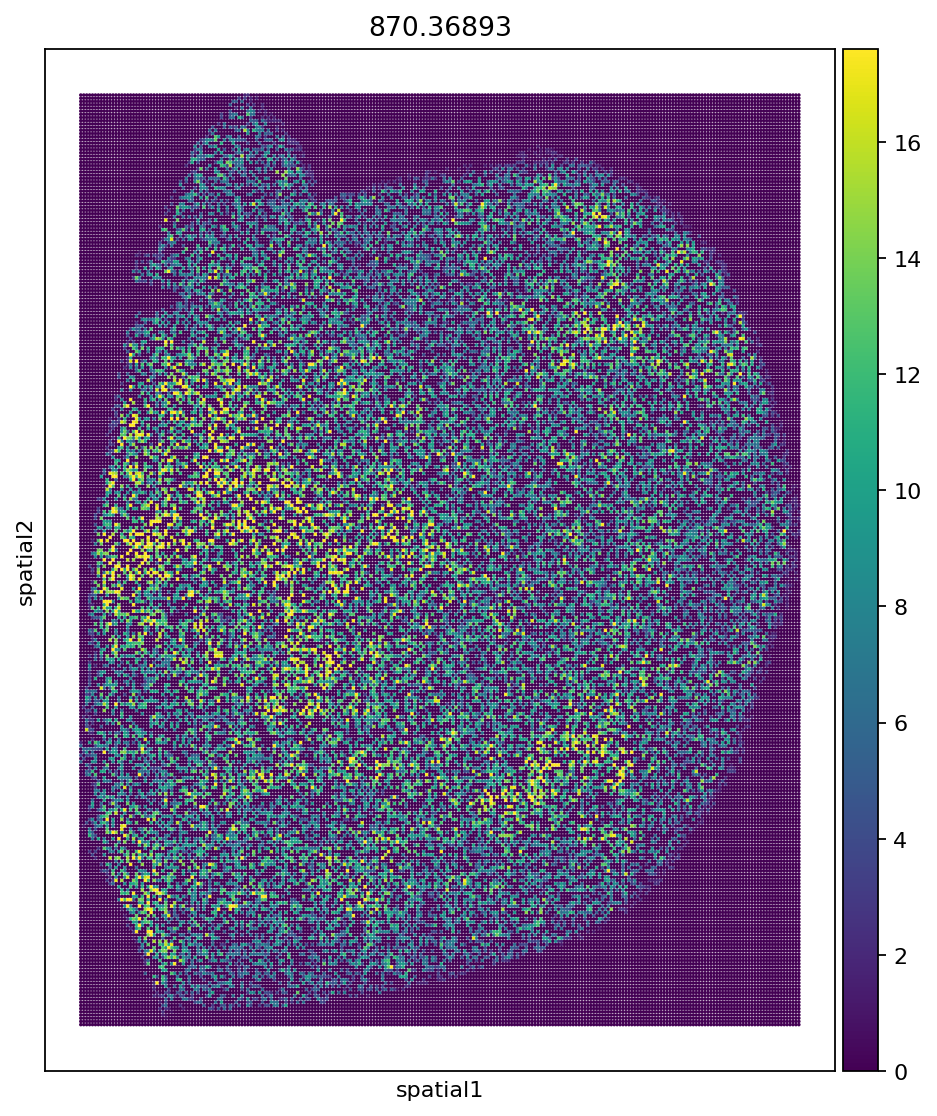

In [44]:
sc.set_figure_params(figsize = (7,8.3), scanpy = False)
sc.pl.embedding(adata, basis = 'spatial', color = '870.36893', vmax = 'p99', size = 10)

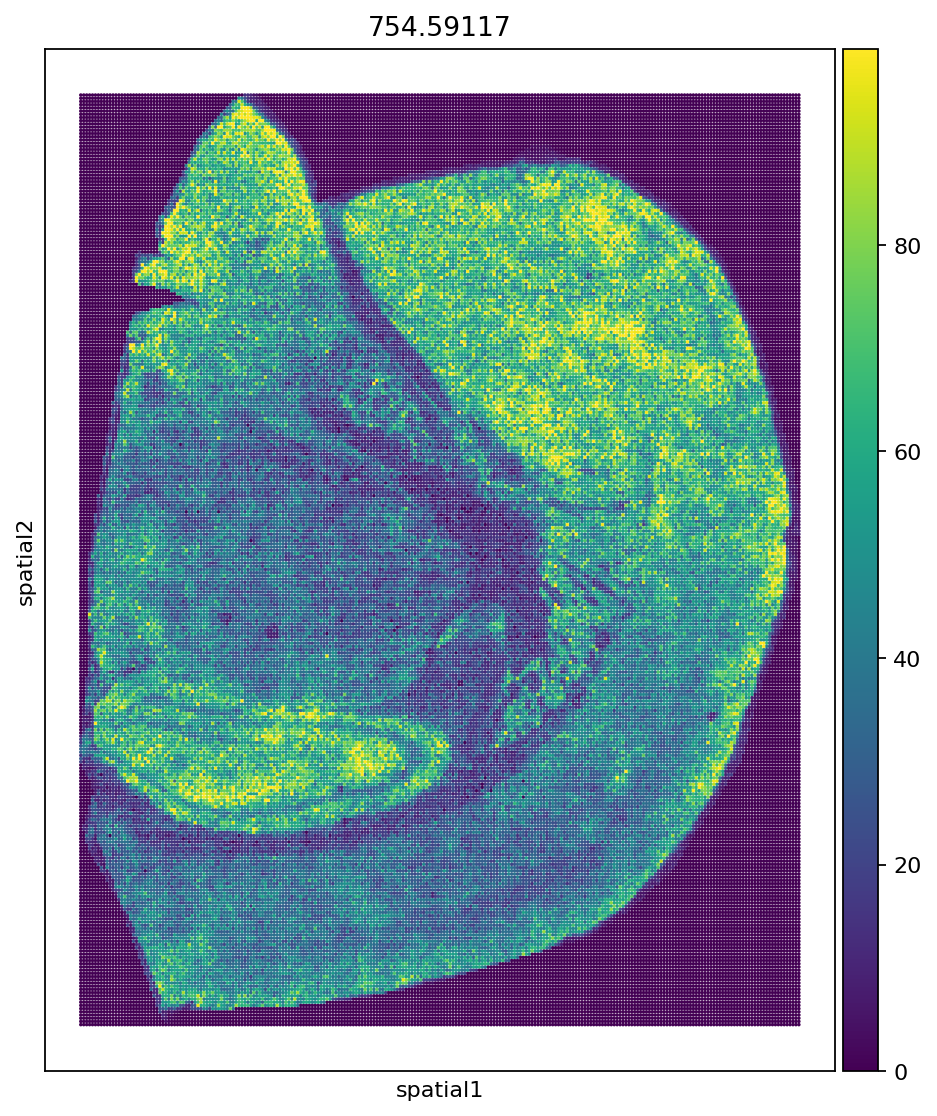

In [92]:
sc.set_figure_params(figsize = (7,8.3), scanpy = False)
sc.pl.embedding(adata, basis = 'spatial', color = '754.59117', vmax = 'p99', size = 10)